## 1. Imports and definitions

In [2]:
import pandas as pd
import numpy as np

# Modelling and Forecasting
# ==============================================================================
import sklearn
import skforecast
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster

# Viz
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
plt.style.use('seaborn-v0_8-darkgrid')


## 2. Read and transform data 

In [6]:
# Read data in
data_dir = '../../Data/queensland/processed'
file = '/qld_height.csv'

df = pd.read_csv(data_dir + file)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('30min')

df.tail()

,wave_height_bilinga,wave_height_tweed-heads-mk4,wave_height_palm-beach-mk4,wave_height_caloundra-pob,wave_height_gladstone-gpa,wave_height_brisbane-mk4,wave_height_bundaberg,wave_height_townsville,wave_height_mooloolaba,wave_height_cairns,wave_height_mackay-mk4
datetime,,,,,,,,,,,
2024-07-31 21:30:00,NaN,NaN,NaN,NaN,NaN,7.424,NaN,NaN,NaN,NaN,NaN
2024-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,5.898,NaN,NaN,NaN,NaN,NaN
2024-07-31 22:30:00,NaN,NaN,NaN,NaN,NaN,5.673,NaN,NaN,NaN,NaN,NaN
2024-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,5.567,NaN,NaN,NaN,NaN,NaN
2024-07-31 23:30:00,NaN,NaN,NaN,NaN,NaN,6.523,NaN,NaN,NaN,NaN,NaN


In [7]:
# Slice off target variables
# target_vars = ['wave_height', 'wave_period', 'wave_direction']
# df_target = df[target_vars].copy()
# df_target.rename(columns={
#     'wave_height_max':'wave_height',
#     'wave_period_upx':'wave_period',
# }, inplace=True)
# df_target

In [5]:
# # Transform wave direction variable into a cyclical variable, as the original variable is in degrees, from 0 to 360
# direction_cycle = cyclical_encoding(df['wave_direction'], cycle_length=360)

# # Replace direction variable with one of the produced variables. Could be either sine or cosine, we are indifferent
# df_target['wave_direction_sine'] = direction_cycle['wave_direction_sin']
# df_target.drop(columns = ['wave_direction'], inplace = True)
# df_target


In [9]:
# Train-test split
# ==============================================================================
one_month = (-1)*30*48 # One month
two_months = (-1)*60*48 # Two months

end_val = two_months
end_train = end_val + two_months 

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2021-01-01 00:00:00 --- 2024-04-02 23:30:00  (n=57024)
Validation dates : 2024-04-03 00:00:00 --- 2024-06-01 23:30:00  (n=2880)
Test dates       : 2024-06-02 00:00:00 --- 2024-07-31 23:30:00  (n=2880)


## 3. Modelling - multiseries model

In [17]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
items = list(df_target.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=42),
                    lags               = 24,
                    encoding           = 'ordinal'
                  #   transformer_series = {'wave_direction':SineCosineEncoder()}
                )
# Backtesting forecaster for all items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = df_target,
                                       levels                = None,
                                       steps                 = 24,
                                       metric                = 'mean_absolute_error',
                                    #    add_aggregated_metric = False,
                                       initial_train_size    = len(df_train) + len(df_val),
                                       refit                 = False,
                                       fixed_train_size      = False,
                                       verbose               = False,
                                       show_progress         = True 
                                    )
# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))



/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:783: MissingValuesWarning:

NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:805: MissingValuesWarning:

NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 107196, number of used features: 25
[LightGBM] [Info] Start training from score -0.000442


  0%|          | 0/120 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,wave_height,0.321054
1,wave_period,0.326580
2,wave_direction,9.077448


,wave_height,wave_period,wave_direction
2024-02-01 00:00:00,3.697181,5.716295,104.360825
2024-02-01 00:30:00,3.647067,5.737963,105.140727
2024-02-01 01:00:00,3.651655,5.769890,104.891603


In [25]:
predictions_ms

,wave_height,wave_period,wave_direction
2024-02-01 00:00:00,3.697181,5.716295,104.360825
2024-02-01 00:30:00,3.647067,5.737963,105.140727
2024-02-01 01:00:00,3.651655,5.769890,104.891603
2024-02-01 01:30:00,3.688061,5.733783,104.427792
2024-02-01 02:00:00,3.693120,5.736864,104.591361
...,...,...,...
2024-03-31 21:30:00,2.229152,5.387148,82.186984
2024-03-31 22:00:00,2.236839,5.394861,81.987263
2024-03-31 22:30:00,2.238886,5.389770,82.130535
2024-03-31 23:00:00,2.231198,5.389770,82.130535


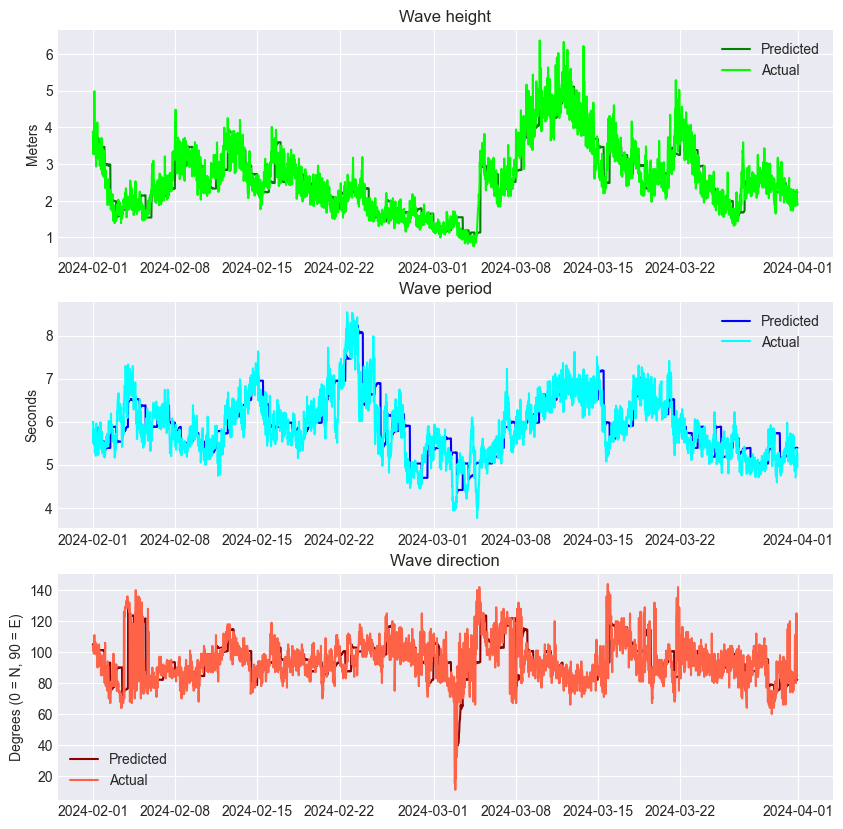

In [26]:
# Plot predictions vs real value
# ======================================================================================
fig, ax = plt.subplots(3, 1, figsize = (10,10))

ax[0].plot(predictions_ms['wave_height'], color = 'green', label = 'Predicted')
ax[0].plot(df_test['wave_height'], color = 'lime', label = 'Actual')
ax[0].set_ylabel('Meters')
ax[0].set_title('Wave height')

ax[1].plot(predictions_ms['wave_period'], color = 'blue', label = 'Predicted')
ax[1].plot(df_test['wave_period'], color = 'cyan', label = 'Actual')
ax[1].set_ylabel('Seconds')
ax[1].set_title('Wave period')

ax[2].plot(predictions_ms['wave_direction'], color = 'darkred', label = 'Predicted')
ax[2].plot(df_test['wave_direction'], color = 'tomato', label = 'Actual')
ax[2].set_ylabel('Degrees (0 = N, 90 = E)')
ax[2].set_title('Wave direction')

for axi in ax:
    axi.legend()

plt.show()

### 3.2 Hyperparameter search

In [27]:
# Hyperparameter search for the multi-series model and backtesting for each item
# ======================================================================================
def search_space(trial):
    search_space = {
        'lags': trial.suggest_categorical('lags', [24, 36, 48]),
        'n_estimators': trial.suggest_int('n_estimators', 600, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 6, 12, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5, step=0.1),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.5, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1, step=0.1),
        # 'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.2, step=0.05),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 30, step=5)
    }
    
    return search_space

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=42),
                    lags               = 24,
                    # transformer_series = StandardScaler(),
                    encoding           = 'ordinal'
                )

results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster_ms,
                        series             = df_target.iloc[:end_val, :],
                        levels             = None, # If None all levels are selected
                        search_space       = search_space,
                        n_trials           = 40,
                        steps              = 24,
                        metric             = 'mean_absolute_error',
                        initial_train_size = len(df_train),
                        refit              = False,
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False,
                        show_progress      = False 
                    )      

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster             = forecaster_ms,
                                       series                 = df_target,
                                       levels                 = None, # If None all levels are selected
                                       steps                  = 24,
                                       metric                 = 'mean_absolute_error',
                                        # add_aggregated_metric = False,
                                       initial_train_size     = len(df_train) + len(df_val),
                                       refit                  = False,
                                       fixed_train_size       = False,
                                       verbose                = False
                                   )

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:783: MissingValuesWarning:

NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:805: MissingValuesWarning:

NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12243
[LightGBM] [Info] Number of data points in the train set: 98503, number of used features: 49
[LightGBM] [Info] Start training from score -0.000950


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 98539, number of used features: 37
[LightGBM] [Info] Start training from score -0.000739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6123
[LightGBM] [Info] Number of data points in the train set: 98575, number of used features: 25
[LightGBM] [Info] Start training from score -0.000451


/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)
  warnings.warn(
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/utils/utils.py:799: MissingValuesWarning: `last_window` has missing values. Most of machine learning models do not allow missing values. `predict` method may fai

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 107160, number of used features: 37
[LightGBM] [Info] Start training from score -0.000723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
  Parameters: {'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.07410276122414056, 'subsample': 1.0, 'colsample_bytree': 0.8}
  Backtesting metric: 5.210277046910219
  Levels: ['wave_height', 'wave_period', 'wave_direction']



/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:783: MissingValuesWarning:

NaNs detected in `y_train`. They have been dropped because the target variable cannot have NaN values. Same rows have been dropped from `X_train` to maintain alignment. This is caused by series with interspersed NaNs. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)

/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/ForecasterAutoregMultiSeries/ForecasterAutoregMultiSeries.py:805: MissingValuesWarning:

NaNs detected in `X_train`. Some regressors do not allow NaN values during training. If you want to drop them, set `forecaster.dropna_from_series = True`. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesWarning)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9183
[LightGBM] [Info] Number of data points in the train set: 107160, number of used features: 37
[LightGBM] [Info] Start training from score -0.000723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  0%|          | 0/120 [00:00<?, ?it/s]

In [28]:
# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))

,levels,mean_absolute_error
0,wave_height,0.325864
1,wave_period,0.323314
2,wave_direction,9.081677


,wave_height,wave_period,wave_direction
2024-02-01 00:00:00,3.658700,5.705511,105.098995
2024-02-01 00:30:00,3.619862,5.729185,105.445840
2024-02-01 01:00:00,3.654607,5.745063,104.474127


In [29]:
# Save the model to a file using pickle
import pickle
with open('../../Models/mooloolaba/forecaster_mool.pkl', 'wb') as file:
    pickle.dump(forecaster_ms, file)

In [30]:
forecaster_ms

ForecasterAutoregMultiSeries 
Regressor: LGBMRegressor(colsample_bytree=0.8, learning_rate=0.07410276122414056,
              max_depth=8, n_estimators=700, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Series encoding: ordinal 
Window size: 36 
Series levels (names): ['wave_height', 'wave_period', 'wave_direction'] 
Series weights: None 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: ["'wave_height': ['2022-01-01 00:00:00', '2024-01-31 23:30:00']", "'wave_period': ['2022-01-01 00:00:00', '2024-01-31 23:30:00']", "'wave_direction': ['2022-01-01 00:00:00', '2024-01-31 23:30:00']"] 
Training index type: DatetimeIndex 
Training index frequency: 30T 
Regressor parameters: boosting_type: gbdt, class_weight: Non

In [42]:
# Load model back
# with open('forecaster.pkl', 'rb') as file:
#     forecaster = pickle.load(file)

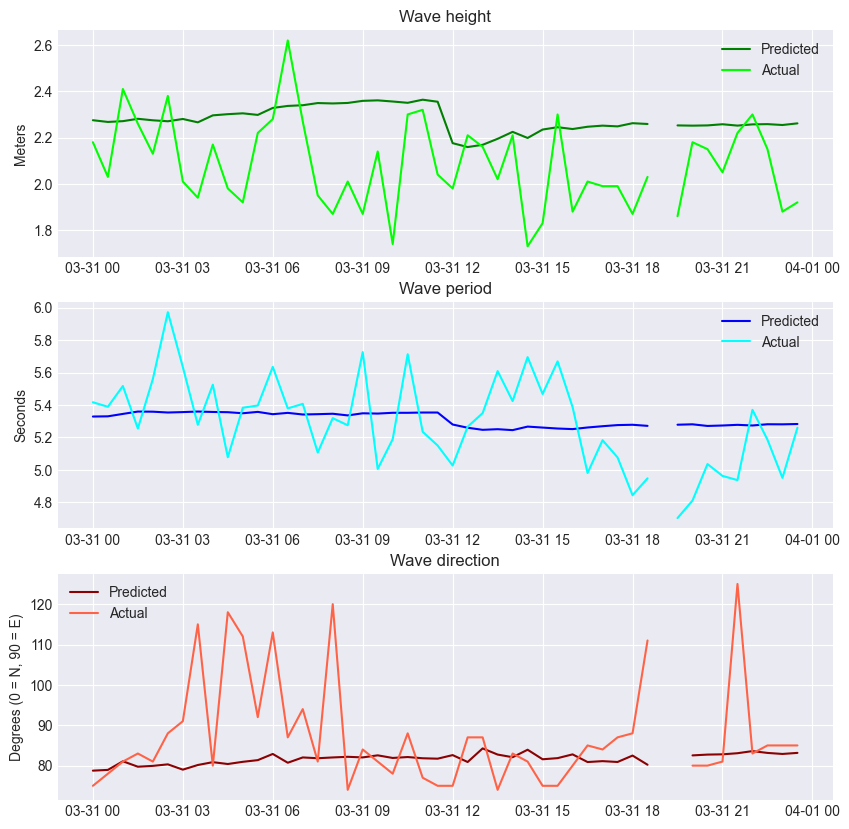

In [12]:
# Plot predictions vs real value
# ======================================================================================
fig, ax = plt.subplots(3, 1, figsize = (10,10))

ax[0].plot(predictions_ms['wave_height'][-48:], color = 'green', label = 'Predicted')
ax[0].plot(df_test['wave_height'][-48:], color = 'lime', label = 'Actual')
ax[0].set_ylabel('Meters')
ax[0].set_title('Wave height')

ax[1].plot(predictions_ms['wave_period'][-48:], color = 'blue', label = 'Predicted')
ax[1].plot(df_test['wave_period'][-48:], color = 'cyan', label = 'Actual')
ax[1].set_ylabel('Seconds')
ax[1].set_title('Wave period')

ax[2].plot(predictions_ms['wave_direction'][-48:], color = 'darkred', label = 'Predicted')
ax[2].plot(df_test['wave_direction'][-48:], color = 'tomato', label = 'Actual')
ax[2].set_ylabel('Degrees (0 = N, 90 = E)')
ax[2].set_title('Wave direction')

for axi in ax:
    axi.legend()

plt.show()

In [13]:
results_bayesian_ms[0].head(2)

,levels,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,subsample,colsample_bytree
21,"[wave_height, wave_period, wave_direction]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 700, 'max_depth': 8, 'learnin...",5.210277,700.0,8.0,0.074103,1.0,0.8
1,"[wave_height, wave_period, wave_direction]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 900, 'max_depth': 9, 'learnin...",5.227316,900.0,9.0,0.015371,0.7,0.9


In [14]:
results_bayesian_ms[0]['lags'][0]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])